In [1]:
from data import *
from config import *
from classifer import *
print("using device: ", device)
random_state = 333
import pandas as pd
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


Random seed set to 333
using device:  cpu


In [2]:
# # ---- update configs ----
# overwrite = False
# model_name = 'binary_hr_death'
# text_config['cl']['die7d'] = True # udpate text_config here if needed
# txt_ls = ['will die', 'will survive']

# update_config(
#     model_name = model_name,
#     ts_aug = False,
#     ts_normalize = False,
#     ts_encode = False,
#     balance = False,
#     block_target = False,
#     txt_ls = txt_ls,
#     patience = 10,
#     num_saves = 20,
#     num_epochs = 100,
#     text_config = text_config
# )
# config_dict = get_config_dict()
# config_dict

In [3]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = gen_text_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = gen_text_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64
This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  No Bradycardia events.   Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64
This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  No Bradycardia events.  It shows high variability.  Low amount of consecutive increases. 


In [4]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# ---- downsample negative class(es) ----
# sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
neg_sample_size = 5000
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
                                    K=10,
                                    max_size=max_size)


# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)

def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df

y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)


y_true_train = y_true_train.float()
y_true_test = y_true_test.float() 
train_loader = prepare_basedata(ts_df_train, y_true_train)
test_loader = prepare_basedata(ts_df_test, y_true_test)

# get number of positives in y_true_train
pos_count = (y_true_train[:,0] == 1).sum().item()
print(f"Number of positives in y_true_train: {pos_count}")

# get number of positives in y_true_test
pos_count = (y_true_test[:,0] == 1).sum().item()
print(f"Number of positives in y_true_test: {pos_count}")


(5384, 300)
(5241, 300)
Number of positives in y_true_train: 384
Number of positives in y_true_test: 241


# baseline models to predict clinical outcomes end2end

In [7]:
# Create different types of models
resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=16, num_blocks=1, dropout=0.5)
model = GeneralBinaryClassifier(resnet_encoder)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=20,          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)


Layer (type:depth-idx)                        Param #
GeneralBinaryClassifier                       --
├─ResNetEncoder: 1-1                          --
│    └─Sequential: 2-1                        --
│    │    └─Linear: 3-1                       38,528
│    │    └─BatchNorm1d: 3-2                  256
│    │    └─LeakyReLU: 3-3                    --
│    │    └─Dropout: 3-4                      --
│    │    └─ResidualBlock: 3-5                33,536
│    │    └─Linear: 3-6                       2,064
│    │    └─BatchNorm1d: 3-7                  32
├─Linear: 1-2                                 34
Total params: 74,450
Trainable params: 74,450
Non-trainable params: 0


Epoch [1/300]
	Train Loss: 0.1355	Test Loss: 0.2348
	Train F1: 0.6946	Test F1: 0.0297
	Train AUROC: 0.9931	Test AUROC: 0.5539
	Train AUPRC: 0.9325	Test AUPRC: 0.0701
	Learning Rate: 0.000038742
Epoch [2/300]
	Train Loss: 0.1392	Test Loss: 0.2318
	Train F1: 0.7055	Test F1: 0.0290
	Train AUROC: 0.9930	Test AUROC: 0.5537
	Train AUPRC: 0.9330	Test AUPRC: 0.0692
	Learning Rate: 0.000038742
Epoch [3/300]
	Train Loss: 0.1413	Test Loss: 0.2302
	Train F1: 0.6550	Test F1: 0.0078
	Train AUROC: 0.9935	Test AUROC: 0.5527
	Train AUPRC: 0.9384	Test AUPRC: 0.0688
	Learning Rate: 0.000038742
Epoch [4/300]
	Train Loss: 0.1402	Test Loss: 0.2327
	Train F1: 0.7270	Test F1: 0.0222
	Train AUROC: 0.9934	Test AUROC: 0.5535
	Train AUPRC: 0.9389	Test AUPRC: 0.0694
	Learning Rate: 0.000038742
Epoch [5/300]
	Train Loss: 0.1345	Test Loss: 0.2300
	Train F1: 0.6758	Test F1: 0.0151
	Train AUROC: 0.9934	Test AUROC: 0.5518
	Train AUPRC: 0.9366	Test AUPRC: 0.0694
	Learning Rate: 0.000038742
Epoch [6/300]
	Train Loss: 0.1

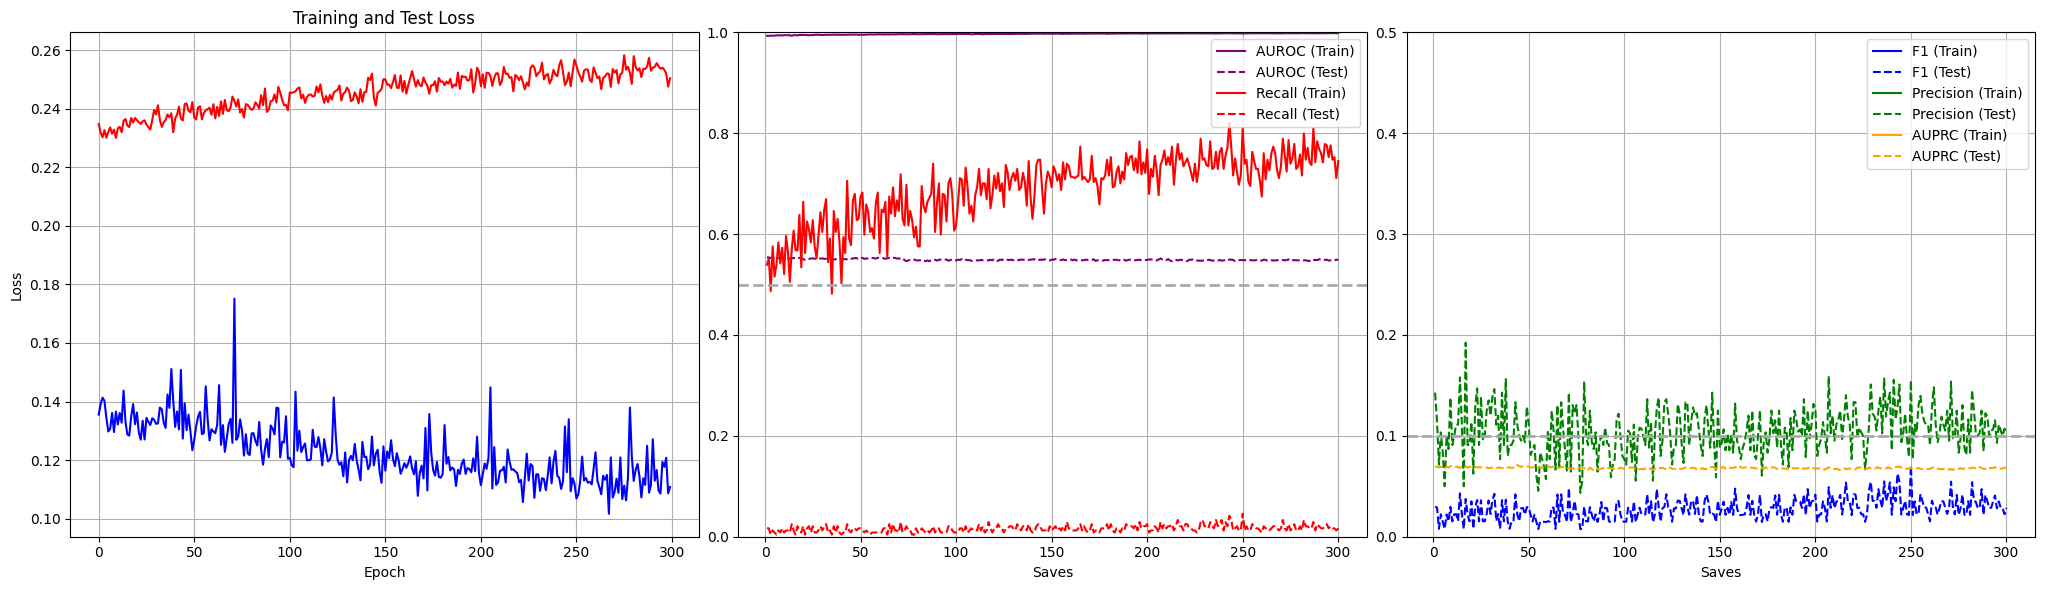

In [10]:

eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
                                                train_loader,
                                                test_loader, 
                                                optimizer, 
                                                scheduler,
                                                300, 
                                                device)
eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True)

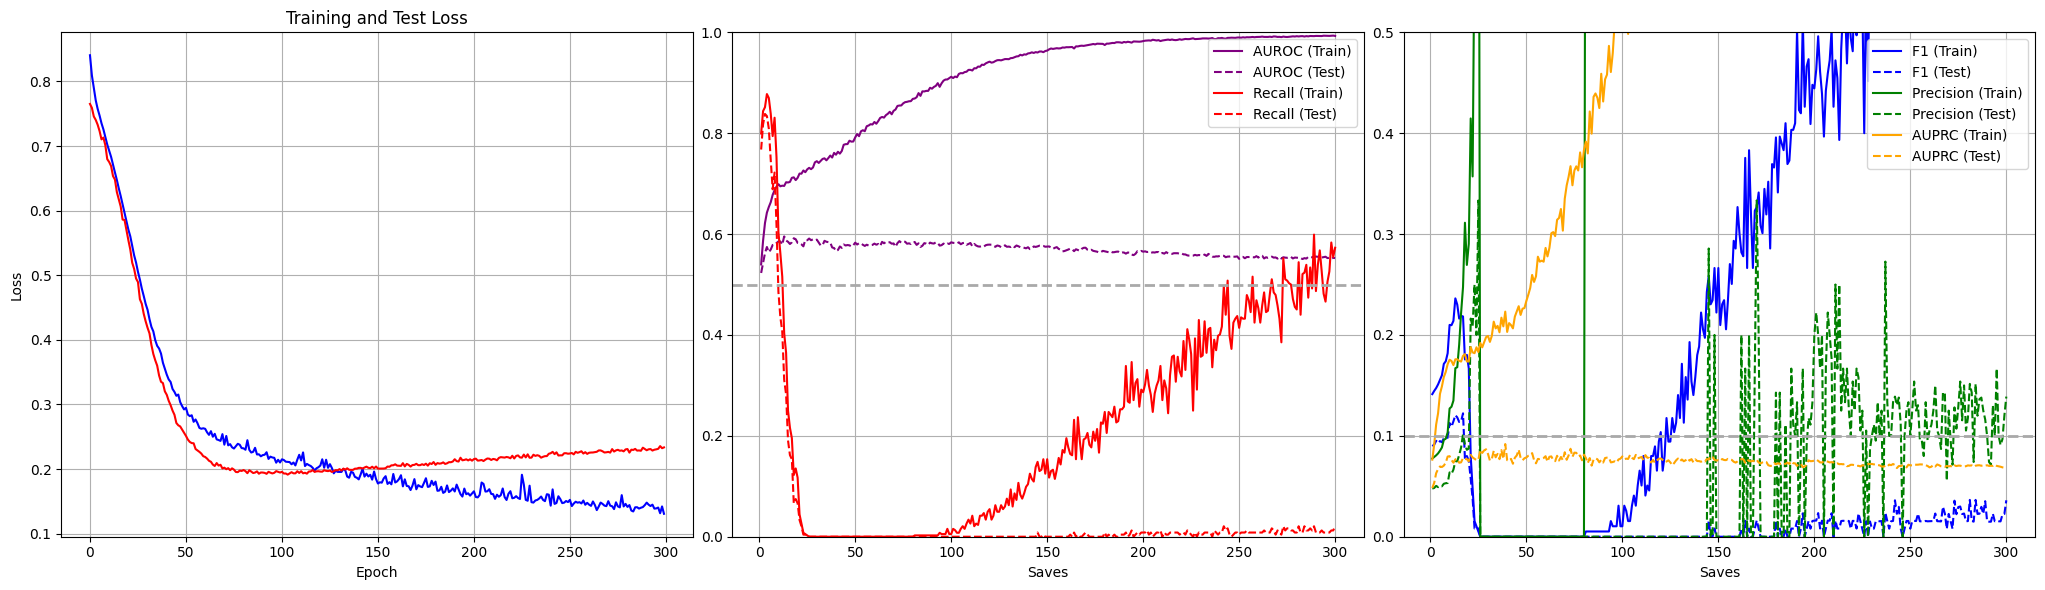

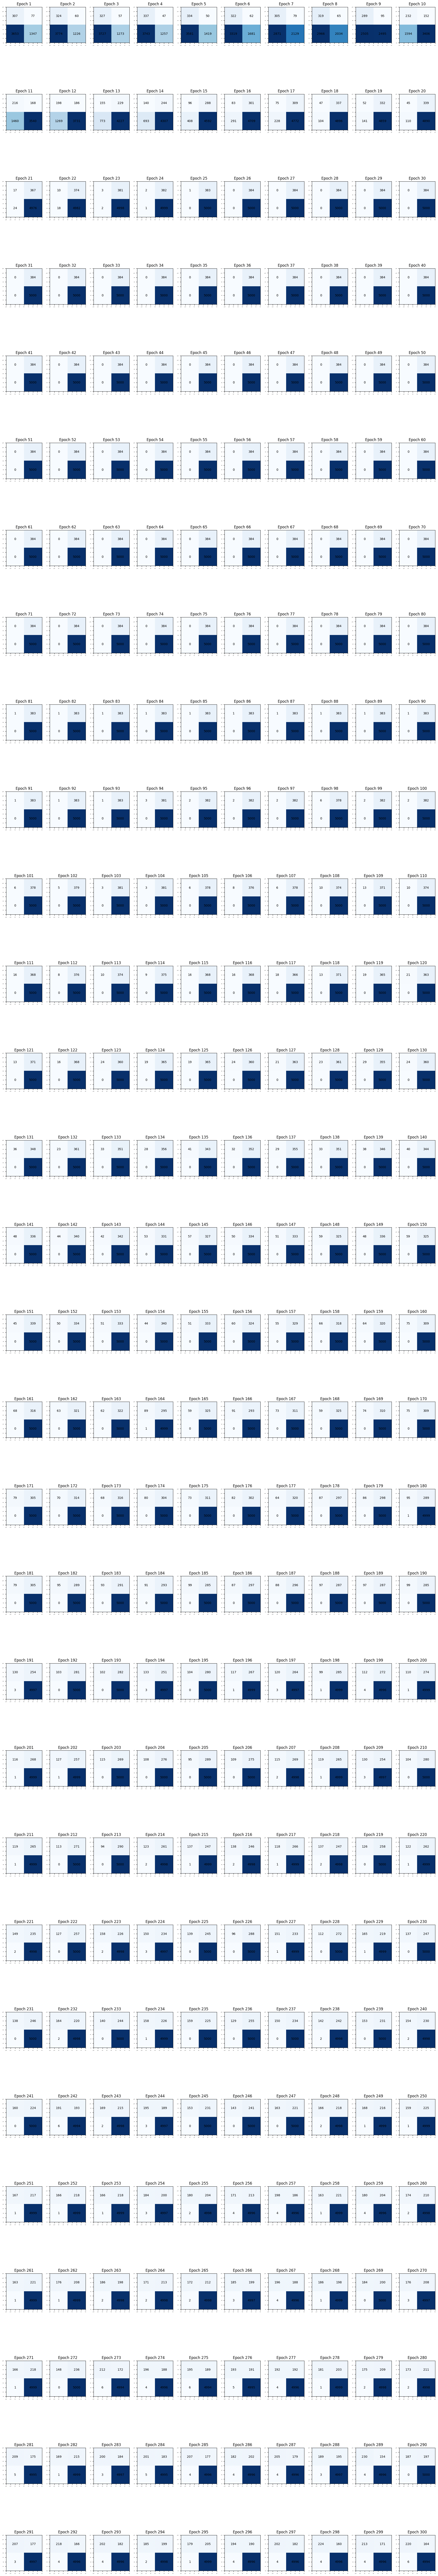

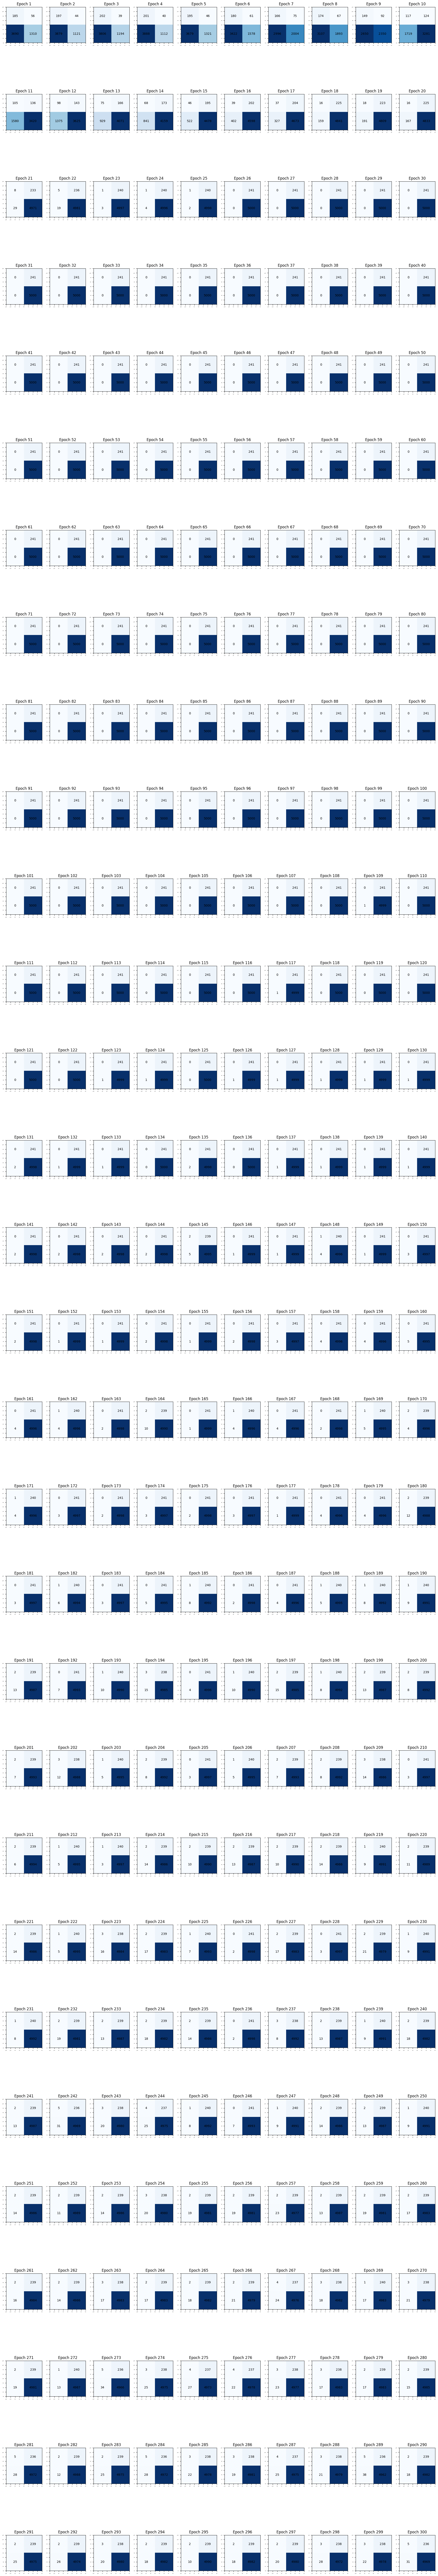

In [9]:

eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True, plot_confusion_matrices=True)

In [ ]:

# train_eval_metrics_list = []
# test_eval_metrics_list = []
# train_losses = []
# test_losses = []

# if overwrite or not os.path.exists(model_path):
    
#     for i in range(config_dict['num_saves']): 
#         eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
#                                                 train_loader,
#                                                 test_loader, 
#                                                 optimizer, 
#                                                 scheduler,
#                                                 config_dict['num_epochs'], 
#                                                 device)
#         train_losses = train_losses + train_losses_tmp
#         test_losses = test_losses + test_losses_tmp

#         train_metrics, test_metrics = eval_binary_classifier(model, 
#                                                              train_loader, 
#                                                              test_loader, 
#                                                              device)
#         train_eval_metrics_list.append(train_metrics)
#         test_eval_metrics_list.append(test_metrics)
#         # save model and losses
#         torch.save(model.state_dict(), model_path)
#         torch.save({'train_losses': train_losses, 
#                     'test_losses': test_losses, 
#                     'train_evals': train_eval_metrics_list, 
#                     'test_evals': test_eval_metrics_list}, eval_path)
#         if i % 10 == 0: # every 10 saves, evaluate the model
#             eval_dict = torch.load(eval_path)
#             eval_dict_eng = eng_eval_metrics(eval_dict, binary=True)
#             print("-" * 70)
#             print(f"Metric     |  Training  |  Testing")
#             print("-" * 70)
#             print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
#             print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
#             print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
#             print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
#             print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
#             print("-" * 70)
    
# else:
#     model.load_state_dict(torch.load(model_path))
#     eval_dict = torch.load(eval_path)
#     train_losses = eval_dict['train_losses']
#     test_losses = eval_dict['test_losses']
#     train_eval_metrics_list = eval_dict['train_evals']
#     test_eval_metrics_list = eval_dict['test_evals']
#     eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=True)